In [1]:
import SimPEG as simpeg
from SimPEG import NSEM
from glob import glob
import numpy as np, sys, matplotlib.pyplot as plt
# sys.path.append('/home/gudni/Dropbox/Work/UBCwork/SyntheticModels/SynGeothermalStructures/ThesisModels')
# import synhelpFunc
%matplotlib inline

/Applications/Anaconda/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [91]:
def convergeCurves(resList):
    its  = np.array([res['iter'] for res in resList]).T
    ind = np.argsort(its)
    phid = np.array([res['phi_d'] for res in resList]).T
    try:
        phim = np.array([res['phi_m'] for res in resList]).T
    except:
        phim = np.array([res['phi_ms'] for res in resList]).T + np.array([res['phi_mx'] for res in resList]).T + np.array([res['phi_my'] for res in resList]).T + np.array([res['phi_mz'] for res in resList]).T     
    x = np.arange(len(its))
    fig, ax1 = plt.subplots()
    ax1.semilogy(x,phid[ind],'bx--')
    ax1.set_ylabel('phi_d', color='b')
    plt.hlines(len(resList[0]['dpred'])*.75,0,len(x),colors='g',linestyles='-.')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    ax2 = ax1.twinx()          
    ax2.semilogy(x,phim[ind],'rx--',)
    ax2.set_ylabel('phi_m', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    ax1.set_xlabel('iteration')
    plt.show()
    
def tikanovCurve(resList):
    its  = np.array([res['iter'] for res in resList]).T
    ind = np.argsort(its)
    phid = np.array([res['phi_d'] for res in resList]).T
    phim = np.array([res['phi_m'] for res in resList]).T
    x = np.arange(len(its))
    fig, ax1 = plt.subplots()
    ax1.loglog(phim[ind],phid[ind],'bx--')
    ax1.set_ylabel('phi_d')
    ax1.set_xlabel('phi_m')
    plt.hlines(len(resList[0]['dpred'])*.75,np.min(phim),np.max(phim),colors='g',linestyles='-.')
    plt.show()
    
def allconvergeCurves(resList):
    its  = np.array([res['iter'] for res in resList]).T
    ind = np.argsort(its)
    phid = np.array([res['phi_d'] for res in resList]).T
    #phim = np.array([res['phi_m'] for res in resList]).T
    phims = np.array([res['phi_ms'] for res in resList]).T
    phimx = np.array([res['phi_mx'] for res in resList]).T
    phimy = np.array([res['phi_my'] for res in resList]).T
    phimz = np.array([res['phi_mz'] for res in resList]).T
    x = np.arange(len(its))
    fig, ax1 = plt.subplots()
    ax1.semilogy(x,phid[ind],'bx--',label='phid')
    ax1.set_ylabel('phi_d', color='b')
    plt.hlines(len(resList[0]['dpred'])*.75,0,len(x),colors='g',linestyles='-.')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')         
    #ax1.semilogy(x,phim[ind],'gx--',label='phim')
    ax1.semilogy(x,phims[ind],'y,--',label='phims')
    ax1.semilogy(x,phimx[ind],'r.--',label='phimx')
    ax1.semilogy(x,phimy[ind],'r+--',label='phimy')
    ax1.semilogy(x,phimz[ind],'r*--',label='phimz')
    
    plt.legend()
    plt.show()

def loadInversionMakeVTRFiles(dirStr,mesh,mapping):
    temp = [np.load(f) for f in glob(dirStr+'/*Inversion*.npz')]
    iterResults = [i if len(i.keys()) > 1 else i['arr_0'].tolist() for i in temp ]
    # Make the vtk models
    for it in iterResults:
        mesh.writeVTK(dirStr+'/recoveredMod_{:s}_it{:.0f}.vtr'.format(dirStr,int(it['iter'])),{'S/m':mapping*it['m']})
    return iterResults

def getDataInfo(MTdata):

    dL, freqL, rxTL = [], [], []

    for src in MTdata.survey.srcList:
        for rx in src.rxList:
            dL.append(MTdata[src,rx])
            freqL.append(np.ones(rx.nD)*src.freq)
            rxTL.extend( ((rx.rxType+' ')*rx.nD).split())
    return np.concatenate(dL), np.concatenate(freqL), np.array(rxTL)


In [3]:
# Load the model
mesh, modDict = simpeg.Mesh.TensorMesh.readVTK('../ForwardModeling_noExtension_Coarse/nsmesh_CoarseHKPK1_NoExtension.vtr')
sigma = modDict['S/m']

In [4]:
# Make the mapping
active = sigma != 1e-8
actMap = simpeg.Maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.nC)
mappingExpAct = simpeg.Maps.ExpMap(mesh) * actMap

### Run_thibaut4_offdiag

In [37]:
# Load the data
drecAll = np.load('./run_thibaut4_off/MTdataStArr_nsmesh_HKPK1Coarse_noExtension.npy')
# Select larger frequency band for the MT data
indMTFreq = np.sum([drecAll['freq'] == val for val in  np.unique(drecAll['freq'])],axis=0,dtype=bool)
mtRecArr = drecAll[indMTFreq][['freq','x','y','z','zxy','zyx']]
dUse = NSEM.Data.fromRecArray(mtRecArr)
# Extract to survey
survey = dUse.survey

In [65]:
dobs, freqArr, rxT = getDataInfo(dUse)
# Set the data

survey.dobs = dobs

#Find index of each type of data
offind = np.array([('zxy' in l or 'zyx' in l) for l in rxT],bool)
tipind = np.array([('tzy' in l or 'tzx' in l) for l in rxT],bool)

#Check if we got all data type covered
assert (offind + tipind).all() , 'Some indicies not included'

#Initialize std
std = np.zeros_like(dobs) # 5% on all off-diagonals

#Std for off diagonal 5% + 0.001*median floor
std = np.abs(survey.dobs*0.05)

#std for tipper: floor of 0.001*median
#std[tipind] = np.abs(np.median(survey.dobs[tipind])*0.001)
# std[np.array([ ('xx' in l or 'yy' in l) for l in rxT])] = 0.15 # 15% on the on-diagonal
survey.std = std 
# Estimate a floor for the data.
# Use the 10% of the mean of the off-diagonals for each frequency
#onind = np.array([('zxx' in l or 'zyy' in l) for l in rxT],bool)

floor = np.zeros_like(dobs)
#floortip = 0.001

for f in np.unique(freqArr):
    freqInd = freqArr == f
    floorFreq = floor[freqInd]
    offD = np.sort(np.abs(dobs[freqInd*offind]))
    floor[freqInd] = 0.001*np.mean(offD)
    # onD = np.sort(np.abs(dobs[freqInd*onind]))
    # floor[freqInd*onind] = 0.1*np.mean(onD)

#floor[tipind] = floortip

# Assign the data weight
Wd = 1./(survey.std + floor)

eps=(survey.std + floor)

In [39]:
runT4fFiles = loadInversionMakeVTRFiles('run_thibaut4_off',mesh,mappingExpAct)

In [40]:
dpred = runT4fFiles[-1]['dpred']

In [77]:
runT4fFiles[-1]['iter']

11

In [78]:
phi_d = (dpred-dobs)/eps

In [87]:
phi_d

array([ 2.02367894,  1.75153898,  1.5836222 , ...,  4.22979608,
        4.00288701,  2.06824994])

In [90]:
np.sum(phi_d**2)/2

24684.478932898735

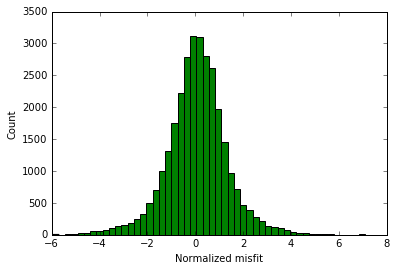

In [95]:
fig=plt.figure()
ax=plt.subplot(111)

n = plt.hist(phi_d,bins=50,color='green')
ax.set_xlabel('Normalized misfit')
ax.set_ylabel('Count')

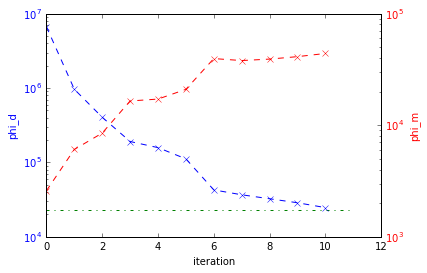

In [92]:
convergeCurves(runT4fFiles)

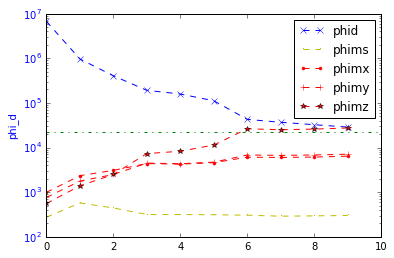

In [24]:
allconvergeCurves(runT4fFiles)

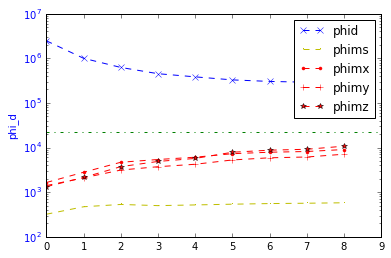

In [25]:
allconvergeCurves(runT4tFiles)

In [26]:
betaoff = [beta['beta'] for beta in runT4fFiles]

In [27]:
betatip = [beta['beta'] for beta in runT4tFiles]

In [28]:
print betaoff

[64.4057731301789, 64.4057731301789, 8.0507216412723626, 8.0507216412723626, 8.0507216412723626, 1.0063402051590453, 1.0063402051590453, 1.0063402051590453, 0.12579252564488067, 0.12579252564488067]


In [29]:
print betatip

[0.13648121755216489, 0.13648121755216489, 0.017060152194020611, 0.017060152194020611, 0.017060152194020611, 0.0021325190242525763, 0.0021325190242525763, 0.0021325190242525763, 0.00026656487803157204]


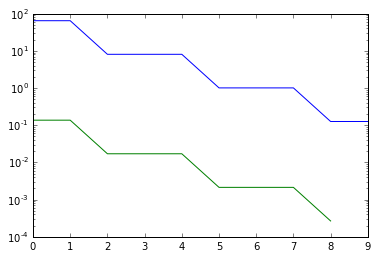

In [30]:
plt.semilogy(betaoff)
plt.semilogy(betatip)

In [31]:
# Load the FW tipper data from last iteration
drecAllft = np.load('../FW_Test_it10_offdiag/MTdataStArr_recoveredMod_run_thibaut4_off_it10.npy')
# Select larger frequency band for the MT data
indMTFreqft = np.sum([drecAllft['freq'] == val for val in  np.unique(drecAllft['freq'])],axis=0,dtype=bool)
mtRecArrft = drecAllft[indMTFreqft][['freq','x','y','z','tzx','tzy']]
dUseft = NSEM.Data.fromRecArray(mtRecArrft)
# Extract to survey
surveyft = dUseft.survey

In [34]:
# # Add noise to the data
dobsft, freqArr, rxT = getDataInfo(dUseft)
# Set the data

survey.dobs = dobsft
# Assign std based on- and off-diagonal parts of the impedance tensor
std = np.ones_like(dobsft)*.05 # 5% on all off-diagonals
# std[np.array([ ('xx' in l or 'yy' in l) for l in rxT])] = 0.15 # 15% on the on-diagonal
survey.std = np.abs(survey.dobs*std) #+ 0.01*np.linalg.norm(survey.dobs) #survey.dobs*0 + std
# Estimate a floor for the data.
# Use the 10% of the mean of the off-diagonals for each frequency
floor = np.zeros_like(dobsft)
offind = np.array([('zxy' in l or 'zyx' in l) for l in rxT],bool)
onind = np.array([('zxx' in l or 'zyy' in l) for l in rxT],bool)
tipind = np.array([('tzx' in l or 'tzy' in l) for l in rxT],bool)

assert (offind+tipind+onind).all()

for f in np.unique(freqArr):
    freqInd = freqArr == f
    floorFreq = floor[freqInd]
    offD = np.sort(np.abs(dobs[freqInd*offind]))
    floor[freqInd] = 0.0001*np.mean(offD)
    onD = np.sort(np.abs(dobs[freqInd*onind]))
    floor[freqInd*onind] = 0.1*np.mean(onD)
    # Constant floor for the tipper.
    floor[freqInd*tipind] = 0.001

# Assign the data weight
Wd = 1./(survey.std + floor)

epsft=(survey.std + floor)

In [35]:
phi_d_ft = (dobsft-dobst)/epsft

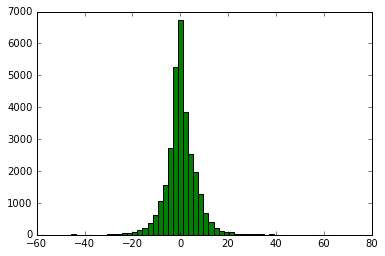

In [36]:
n = plt.hist(phi_d_ft,bins=50,color='green')

### Run_thibaut4_tip

In [45]:
# Load the data
drecAllt = np.load('./run_thibaut4_tip/MTdataStArr_nsmesh_HKPK1Coarse_noExtension.npy')
# Select larger frequency band for the MT data
indMTFreqt = np.sum([drecAllt['freq'] == val for val in  np.unique(drecAllt['freq'])],axis=0,dtype=bool)
mtRecArrt = drecAllt[indMTFreqt][['freq','x','y','z','tzx','tzy']]
dUset = NSEM.Data.fromRecArray(mtRecArrt)
# Extract to survey
survey = dUset.survey

In [46]:
# # Add noise to the data
dobst, freqArr, rxT = getDataInfo(dUset)
# Set the data

survey.dobs = dobst
# Assign std based on- and off-diagonal parts of the impedance tensor
std = np.ones_like(dobst)*.05 # 5% on all off-diagonals
# std[np.array([ ('xx' in l or 'yy' in l) for l in rxT])] = 0.15 # 15% on the on-diagonal
survey.std = np.abs(survey.dobs*std) #+ 0.01*np.linalg.norm(survey.dobs) #survey.dobs*0 + std
# Estimate a floor for the data.
# Use the 10% of the mean of the off-diagonals for each frequency
floor = np.zeros_like(dobst)
offind = np.array([('zxy' in l or 'zyx' in l) for l in rxT],bool)
onind = np.array([('zxx' in l or 'zyy' in l) for l in rxT],bool)
tipind = np.array([('tzx' in l or 'tzy' in l) for l in rxT],bool)

assert (offind+tipind+onind).all()

for f in np.unique(freqArr):
    freqInd = freqArr == f
    floorFreq = floor[freqInd]
    offD = np.sort(np.abs(dobst[freqInd*offind]))
    floor[freqInd] = 0.0001*np.mean(offD)
    onD = np.sort(np.abs(dobst[freqInd*onind]))
    floor[freqInd*onind] = 0.1*np.mean(onD)
    # Constant floor for the tipper.
    floor[freqInd*tipind] = 0.001

# Assign the data weight
Wd = 1./(survey.std + floor)

epst=(survey.std + floor)

In [47]:
runT4tFiles = loadInversionMakeVTRFiles('run_thibaut4_tip',mesh,mappingExpAct)

In [48]:
dpredt =runT4tFiles[-1]['dpred']

In [49]:
[i['iter'] for i in runT4tFiles]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [50]:
phi_d_t = (dpredt-dobst)/epst

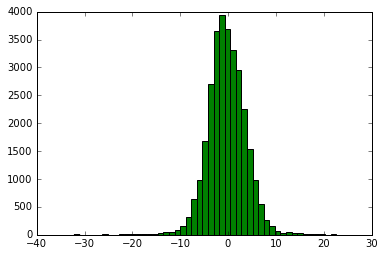

In [51]:
n = plt.hist(phi_d_t,bins=50,color='green')

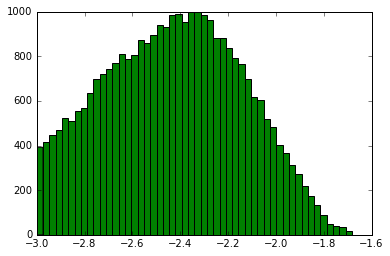

In [52]:
n = plt.hist(np.log10(np.abs(epst)),bins=50,color='green')

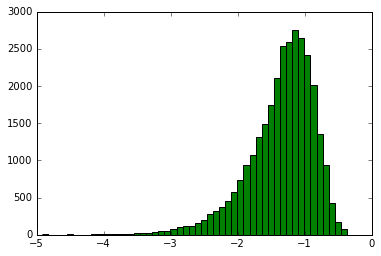

In [53]:
n = plt.hist(np.log10(np.abs(dpredt)),bins=50,color='green')

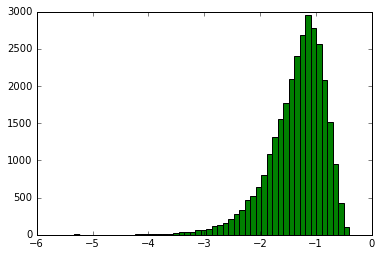

In [54]:
n = plt.hist(np.log10(np.abs(dobst)),bins=50,color='green')

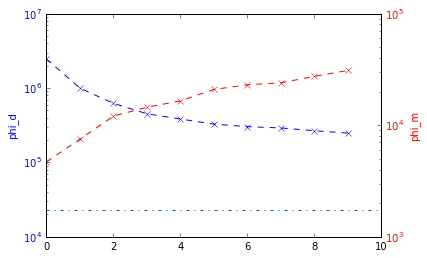

In [55]:
convergeCurves(runT4tFiles)

### run1


In [6]:
run1Files = loadInversionMakeVTRFiles('run1',mesh,mappingExpAct)

In [7]:
ls run1

001-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it10.vtr
002-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it11.vtr
003-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it12.vtr
004-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it13.vtr
005-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it14.vtr
006-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it15.vtr
007-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it16.vtr
008-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it17.vtr
009-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it18.vtr
010-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it19.vtr
011-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it1.vtr
012-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it20.vtr
013-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it21.vtr
014-InversionModel-2016-05-27-12-14.npz  recoveredMod_run1_it22.vtr
015-InversionModel-2016-05-27-12-14.npz  recovere

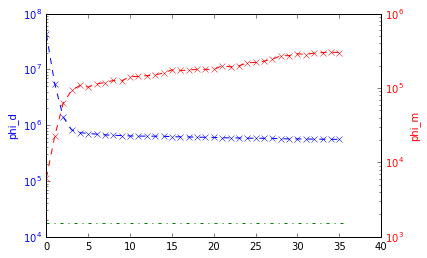

In [8]:
%matplotlib inline
convergeCurves(run1Files)

In [9]:
[res['iter'] for res in run1Files]

[array(11),
 array(1),
 array(9),
 array(5),
 array(15),
 array(22),
 array(8),
 array(4),
 array(6),
 array(13),
 array(18),
 array(31),
 array(27),
 array(20),
 array(7),
 array(35),
 array(12),
 array(28),
 array(25),
 array(16),
 array(19),
 array(10),
 array(23),
 array(26),
 array(2),
 array(14),
 array(3),
 array(32),
 array(21),
 array(36),
 array(29),
 array(24),
 array(33),
 array(34),
 array(17),
 array(30)]

In [10]:
%matplotlib qt
sys.path.append('/home/gudni/Dropbox/code/python/MTview/')
import interactivePlotFunctions as iPf

In [11]:
finData = NSEM.Data(survey,run1Files[0]['dpred']).toRecArray('Complex')

/home/gudni/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:2915: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a structured
array. This code will likely break in a future numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  if (obj.__array_interface__["data"][0]
/home/gudni/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:2916: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a structured
array. This code will likely break in a future numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  != self.__array_interface__["data"][0]):


In [12]:
%matplotlib qt
iPf.MTinteractiveMap([dUse.toRecArray('Complex'),finData])

### run2

In [13]:
run2Files = loadInversionMakeVTRFiles('run2',mesh,mappingExpAct)

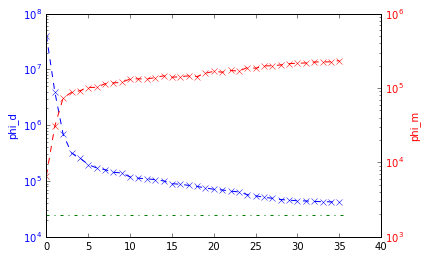

In [14]:
%matplotlib inline
convergeCurves(run2Files)

In [16]:
finData = NSEM.Data(survey,run2Files[0]['dpred']).toRecArray('Complex')

AssertionError: v must have the correct number of data.

## run3

In [17]:
run3Files = loadInversionMakeVTRFiles('run3',mesh,mappingExpAct)

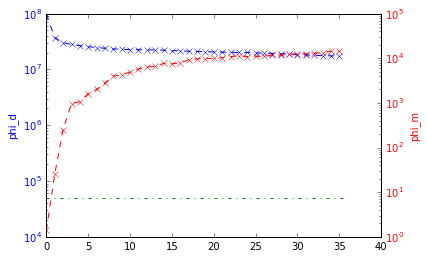

In [18]:
%matplotlib inline
convergeCurves(run3Files)

## run4

In [15]:
run4Files = loadInversionMakeVTRFiles('run4',mesh,mappingExpAct)

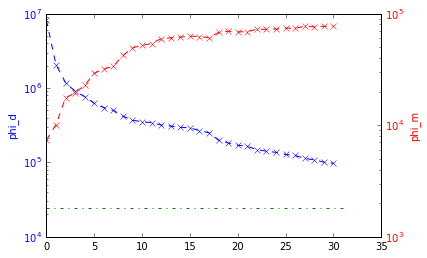

In [16]:
%matplotlib inline
convergeCurves(run4Files)